# Preprocess Hije Data

---

Hije dataset (`../data/hije_mbon_response.mat`) contains **11 odors** (including empty): 
- 'vinegar'
- 'yeast'
- '2-heptanone'
- 'hexanol'
- 'octanol'
- 'mch'
- 'peppermint'
- 'ethanol'
- 'citronella'
- 'co2'
- 'empty'

Which were used to stimulate **16 MBON cell types/combinations**:
- 14 cell types
- 2 cell type combinations
- This covers 18 of the 21 MBON cell types.

Each of the stimuli was presented to each of the regions **5** times.

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import loadmat

%matplotlib inline

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 12

sns.set_style("whitegrid",{"axes.edgecolor": "0",'grid.color': '0','font.family':'Arial'})
sns.set_context("notebook",font_scale=1.5)

DATA_DIR = Path('../data')

## Load data

### 1. Build a dictionary from the Matlab data

In [2]:
data = loadmat('../data/hije_mbon_response.mat')
x = data['Data']

ddict = {}
for i in range(17): 
    if x[0,0][i][0][0][1][0] not in ddict:
        ddict[x[0,0][i][0][0][1][0].replace("\\", '')] = x[0,0][i][0][0][0]

### 2. Build a dataframe

In [3]:
def get_lobe_name(mbon_type:str) -> str:
    '''Given mbon type in the format <lobe_name>xxx, return lobe_name'''
    idx_digit = re.search(r"\d", mbon_type).start()
    return mbon_type[:idx_digit + 1]

In [4]:
odors = ['vinegar', 'yeast', '2-heptanone', 'hexanol', 'octanol', 'mch', 'peppermint', 'ethanol', 'citronella', 'co2', 'empty']
raw_data = pd.DataFrame(columns = ['MBON cell type', 'stimulus', 'dF/F'])

for lobe in ddict.keys():
    # 11 stimuli, 5 trials, 1 cell type
    y = pd.DataFrame.from_dict(ddict[lobe])
    y.columns = odors
    y.index = [lobe for _ in range(5)]
    y = y.stack().reset_index()
    y.columns = ['MBON cell type', 'stimulus', 'dF/F']
    
    raw_data = pd.concat([raw_data, y])


In [5]:
raw_data

,MBON cell type,stimulus,dF/F
0,calyx,vinegar,26.458124
1,calyx,yeast,18.026856
2,calyx,2-heptanone,5.202365
3,calyx,hexanol,6.492893
4,calyx,octanol,-2.514705
...,...,...,...
50,alpha1,peppermint,7.261187
51,alpha1,ethanol,20.986401
52,alpha1,citronella,0.716510
53,alpha1,co2,3.464856


## Process Data

### 1. Clean the data:

First remove unnecesary information:
- Removing the activity in the Calyx (not part of the MB under investigation)
- Remove the `empty` and `co2` stimulus data (not used by Siju)

In [6]:
# Do some cleaning
raw_data = raw_data[raw_data['MBON cell type'] != 'calyx']

uncommon_stimuli = ['empty', 'co2']
raw_data = raw_data[~raw_data["stimulus"].isin(uncommon_stimuli)]

print(raw_data.shape)
raw_data.head()

(720, 3)


,MBON cell type,stimulus,dF/F
0,gamma1pedc,vinegar,66.213579
1,gamma1pedc,yeast,65.091995
2,gamma1pedc,2-heptanone,46.239205
3,gamma1pedc,hexanol,52.249343
4,gamma1pedc,octanol,5.743157


### 2. Understanding cell types and combinations

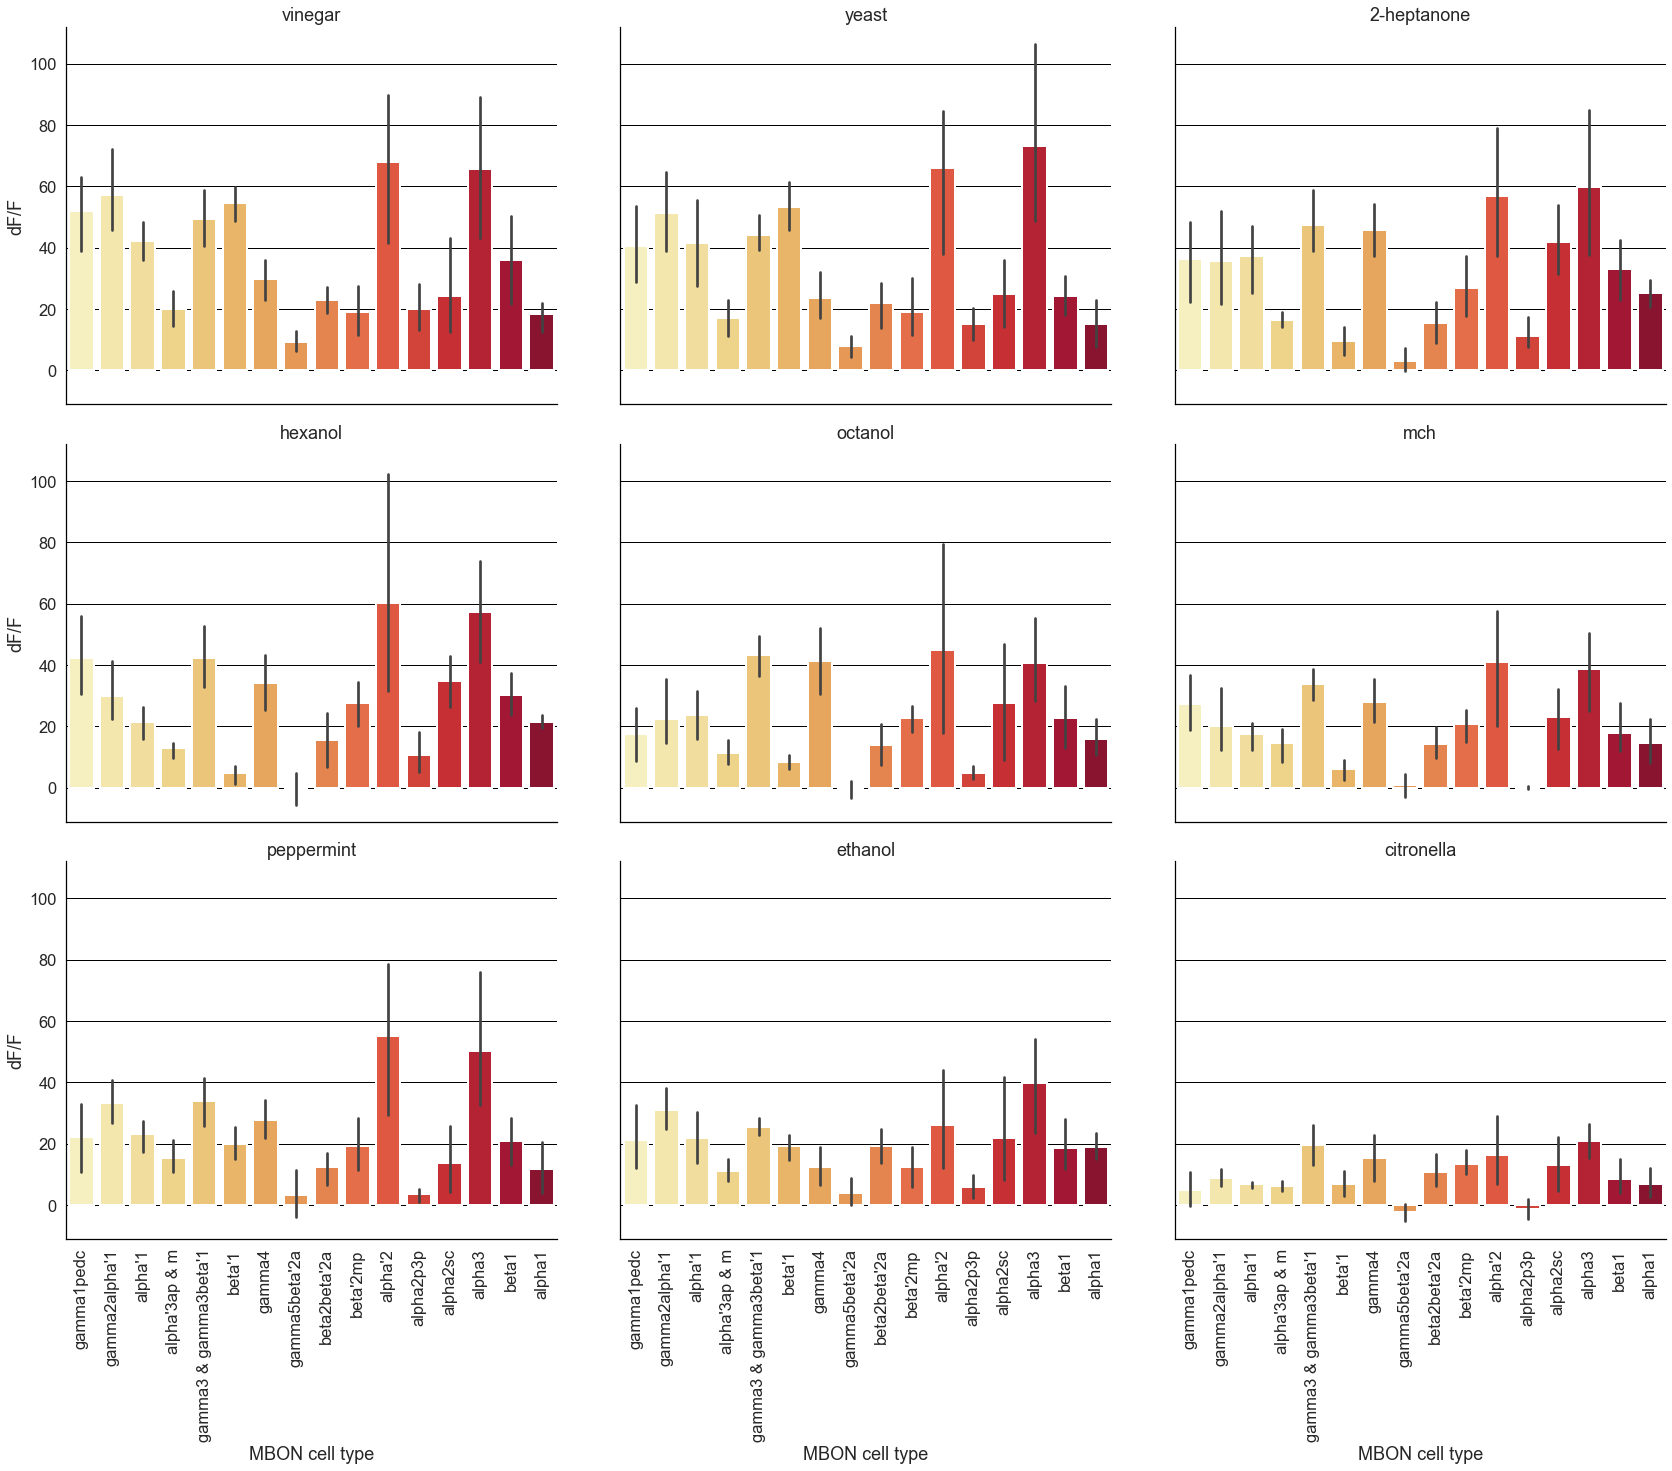

In [11]:
# Plot cell combination/type activity 
# Do the combinations display substancially stronger activation?

b = sns.catplot(
    x="MBON cell type", 
    y="dF/F", 
    col="stimulus", 
    col_wrap=3, 
    data=raw_data, 
    linewidth=2, 
    kind="bar",
    palette='YlOrRd',
    height=6, 
    aspect=1.3
)
b.set_titles("{col_name}") 
b.set_xticklabels(rotation=90)

In [8]:
mbon_types_and_combinations = raw_data['MBON cell type'].unique()
mbon_combinations = [x for x in mbon_types_and_combinations if '&' in x]
mbon_types = list(set(mbon_combinations) ^ set(mbon_types_and_combinations))

print(f"Number of mbon_types_and_combinations: {len(mbon_types_and_combinations)}")
print(f"Number of mbon_types: {len(mbon_types)}")
print(f"Number of mbon_combinations: {len(mbon_combinations)}")
print(f"mbon_combinations: {mbon_combinations}")


Number of mbon_types_and_combinations: 16
Number of mbon_types: 14
Number of mbon_combinations: 2
mbon_combinations: ["alpha'3ap & m", "gamma3 & gamma3beta'1"]


In [9]:
# Sanity check on #experiments per stimulus
number_trials_per_stimulus = raw_data['stimulus'].value_counts()/mbon_types_and_combinations.size
number_trials_per_stimulus = number_trials_per_stimulus.to_frame()
number_trials_per_stimulus.columns = ['experiment count']
number_trials_per_stimulus

,experiment count
citronella,5.0
hexanol,5.0
octanol,5.0
mch,5.0
peppermint,5.0
2-heptanone,5.0
ethanol,5.0
yeast,5.0
vinegar,5.0


### 3. Split combinations into individual cell types

The Hije data is made up of 16 types or combinations of types of MBONs. This covers 18/21 MBON cell types.

__ASSUMPTION__: each cell type in a combination has the same activity as the combination.
- `gamma3 & gamma3beta'1` => `[gamma3, gamma3beta'1]`
- `alpha'3ap & m` => `[alpha'3ap, alpha'3m]`



In [12]:
def replace_combination(df:pd.DataFrame, combination:str, cell_types:list) -> pd.DataFrame:
    '''
    Replaces the combination readings by duplicating its rows for each
    cell type in the combination (not in place).
    TODO: Try reduce the number of copies made and remove for loops..
    '''
    for cell_type in cell_types:
        to_insert = df[df["MBON cell type"] == combination].copy()
        to_insert['MBON cell type'] = cell_type
        df = df.append(to_insert)
    
    df = df[~(df["MBON cell type"] == combination)]
    
    return df

In [13]:
print(f'Before: {raw_data["MBON cell type"].unique()}')

print(raw_data.shape)
raw_data = replace_combination(raw_data, "alpha'3ap & m", ["alpha'3ap", "alpha'3m"])
print(raw_data.shape)
raw_data = replace_combination(raw_data, "gamma3 & gamma3beta'1", ["gamma3", "gamma3beta'1"])
print(raw_data.shape)
      
print(f'After: {raw_data["MBON cell type"].unique()}')

Before: ['gamma1pedc' "gamma2alpha'1" "alpha'1" "alpha'3ap & m"
 "gamma3 & gamma3beta'1" "beta'1" 'gamma4' "gamma5beta'2a" "beta2beta'2a"
 "beta'2mp" "alpha'2" 'alpha2p3p' 'alpha2sc' 'alpha3' 'beta1' 'alpha1']
(720, 3)
(765, 3)
(810, 3)
After: ['gamma1pedc' "gamma2alpha'1" "alpha'1" "beta'1" 'gamma4' "gamma5beta'2a"
 "beta2beta'2a" "beta'2mp" "alpha'2" 'alpha2p3p' 'alpha2sc' 'alpha3'
 'beta1' 'alpha1' "alpha'3ap" "alpha'3m" 'gamma3' "gamma3beta'1"]


In [13]:
raw_data = raw_data.sort_values(by=["MBON cell type", "stimulus"])
raw_data.head(20)

,MBON cell type,stimulus,dF/F
2,alpha'1,2-heptanone,47.942858
13,alpha'1,2-heptanone,50.515459
24,alpha'1,2-heptanone,32.195216
35,alpha'1,2-heptanone,40.542121
46,alpha'1,2-heptanone,15.532834
8,alpha'1,citronella,6.450651
19,alpha'1,citronella,7.304610
30,alpha'1,citronella,7.545683
41,alpha'1,citronella,7.792920
52,alpha'1,citronella,4.272539


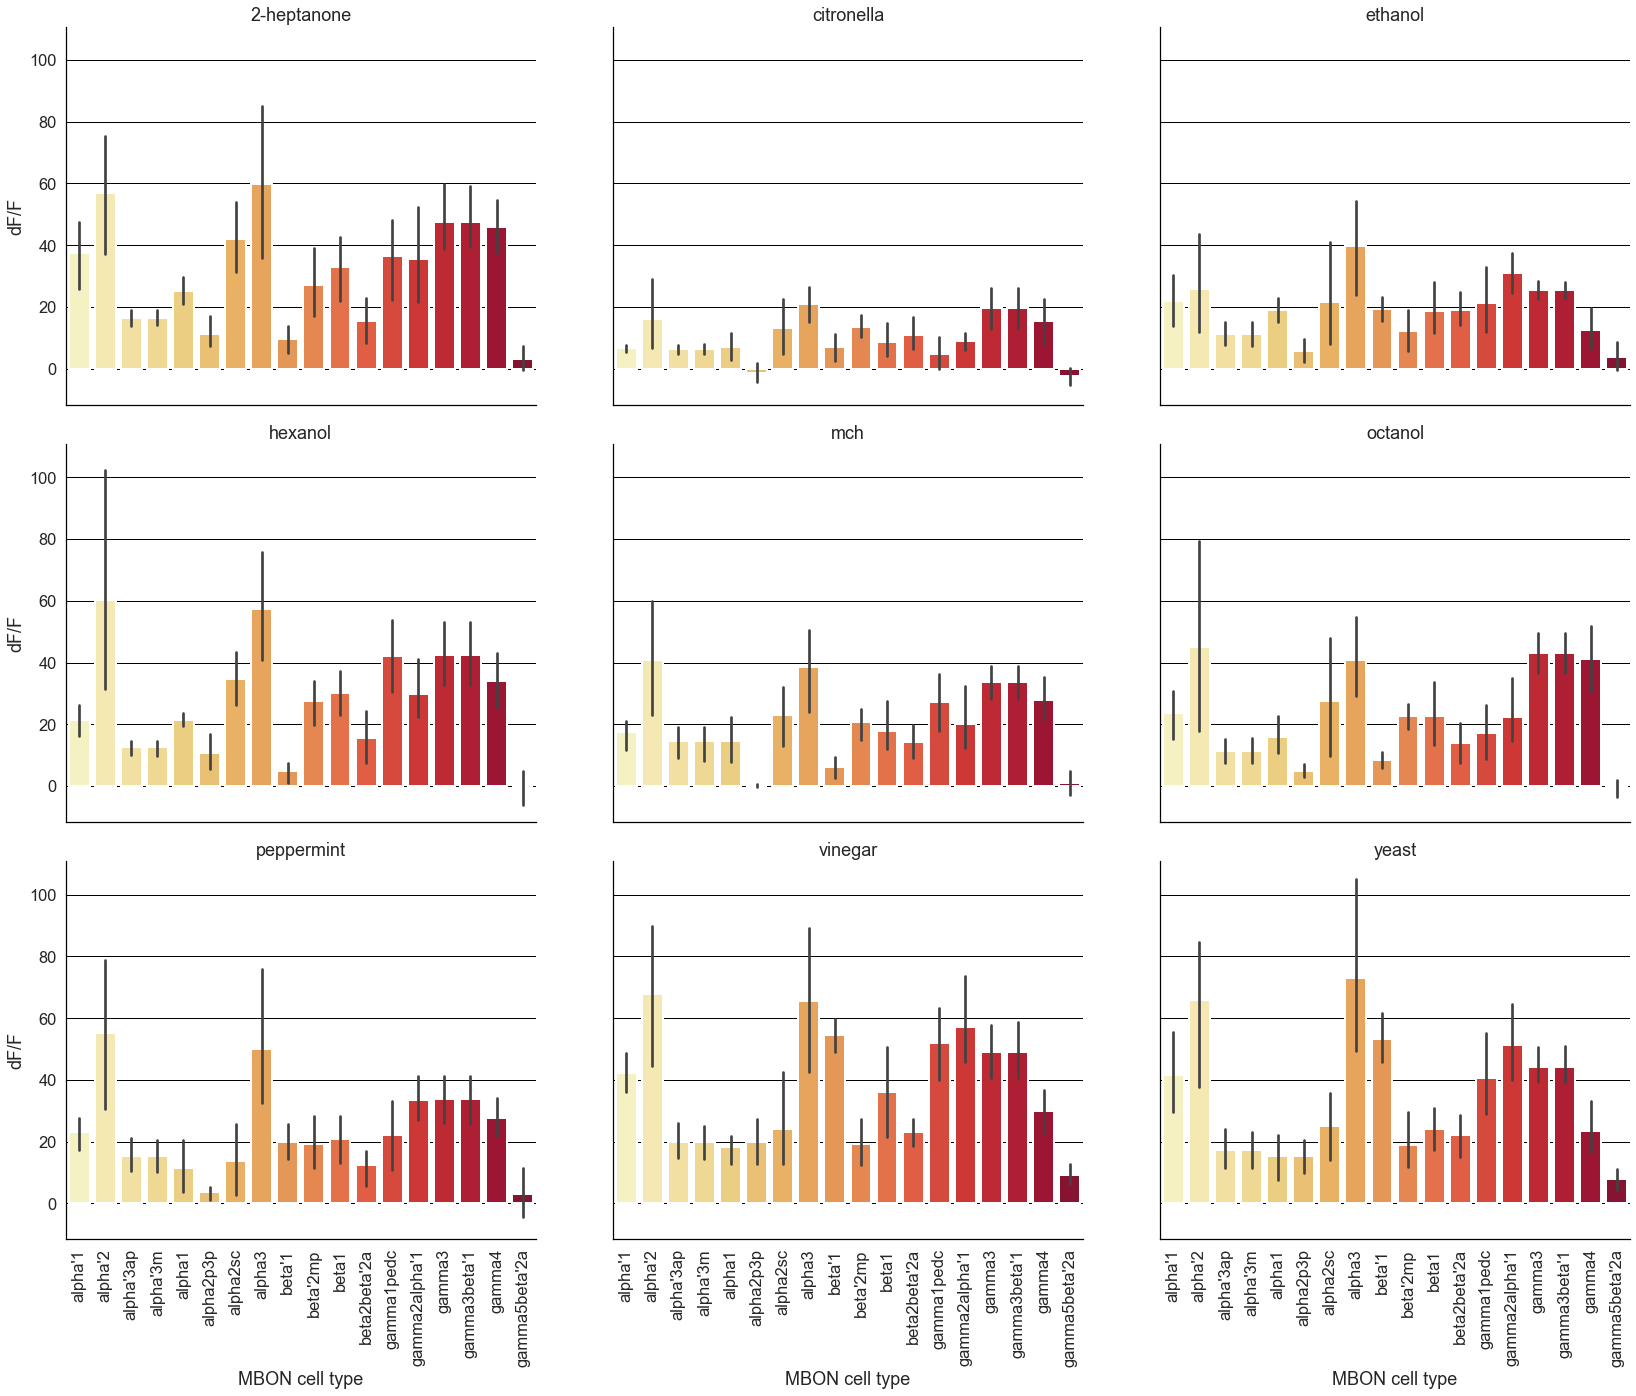

In [15]:
b = sns.catplot(
    x="MBON cell type", 
    y="dF/F", 
    col="stimulus", 
    col_wrap=3, 
    data=raw_data, 
    linewidth=2, 
    kind="bar",
    palette='YlOrRd',
    height=6, 
    aspect=1.3
)
b.set_titles("{col_name}") 
b.set_xticklabels(rotation=90)

## Estimate MBON lobe activity from MBON cell activity

In [16]:
df = raw_data.copy(deep=True)

# Get the mean value of MBON cell activity for each stimulus
df = raw_data.groupby(["MBON cell type", "stimulus"]).mean()
df = df.reset_index()
df

,MBON cell type,stimulus,dF/F
0,alpha'1,2-heptanone,37.345698
1,alpha'1,citronella,6.673281
2,alpha'1,ethanol,21.848225
3,alpha'1,hexanol,21.356445
4,alpha'1,mch,17.463519
...,...,...,...
157,gamma5beta'2a,mch,0.867203
158,gamma5beta'2a,octanol,-0.627063
159,gamma5beta'2a,peppermint,3.140346
160,gamma5beta'2a,vinegar,9.060922


In [19]:
df[df['stimulus'] == 'yeast']

,MBON cell type,stimulus,dF/F
8,alpha'1,yeast,41.415112
17,alpha'2,yeast,65.921205
26,alpha'3ap,yeast,17.172300
35,alpha'3m,yeast,17.172300
44,alpha1,yeast,15.204187
53,alpha2p3p,yeast,15.176325
62,alpha2sc,yeast,25.014518
71,alpha3,yeast,73.104286
80,beta'1,yeast,53.161709
89,beta'2mp,yeast,18.998279


<AxesSubplot:>

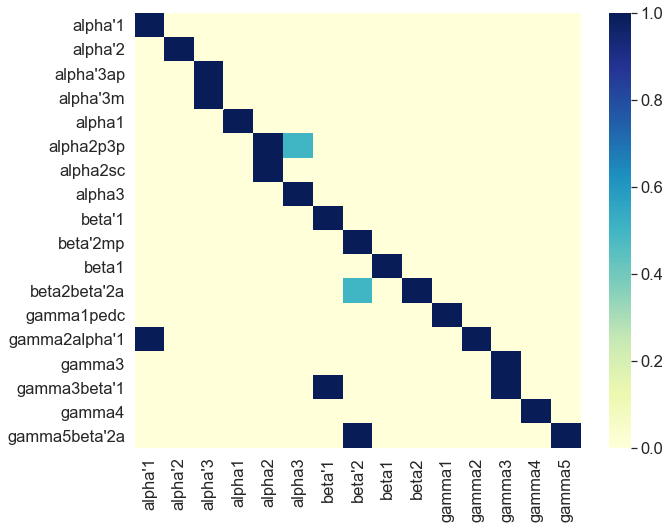

In [17]:
cell_types = raw_data['MBON cell type'].unique()
lobes = []

# Build a weight matrix from Aso 2014, Fig 12 A
W = pd.DataFrame(index = cell_types, columns=lobes)
W.loc["alpha'1", "alpha'1"] = 1.0
W.loc["alpha'2", "alpha'2"] = 1.0
W.loc["alpha'3ap", "alpha'3"] = 1.0
W.loc["alpha'3m", "alpha'3"] = 1.0
W.loc["alpha1", "alpha1"] = 1.0
W.loc["alpha2p3p", "alpha2"] = 1.0
W.loc["alpha2p3p", "alpha3"] = 0.5
W.loc["alpha2sc", "alpha2"] = 1.0
W.loc["alpha3", "alpha3"] = 1.0
W.loc["beta'1", "beta'1"] = 1.0
W.loc["beta'2mp", "beta'2"] = 1.0
W.loc["beta1", "beta1"] = 1.0
W.loc["beta2beta'2a", "beta2"] = 1.0
W.loc["beta2beta'2a", "beta'2"] = 0.5
W.loc["gamma1pedc", "gamma1"] = 1.0
W.loc["gamma2alpha'1", "gamma2"] = 1.0
W.loc["gamma2alpha'1", "alpha'1"] = 1.0
W.loc["gamma3", "gamma3"] = 1.0
W.loc["gamma3beta'1", "gamma3"] = 1.0
W.loc["gamma3beta'1", "beta'1"] = 1.0
W.loc["gamma4", "gamma4"] = 1.0
W.loc["gamma5beta'2a", "gamma5"] = 1.0
W.loc["gamma5beta'2a", "beta'2"] = 1.0

W = W.sort_index(axis=1)
W = W.fillna(0)

plt.figure(figsize=(10,8))
sns.heatmap(W, cmap="YlGnBu", xticklabels=True, yticklabels=True)

In [27]:
final_df = pd.DataFrame(columns=['dF/F', 'lobe'])

for lobe in W.columns:
    # print(f'Lobe: {lobe}')
    
    # Get relevent weights
    lobe_W = W[W[lobe] > 0][lobe]

    # Get a dataframe containing all the cell types contributing to the activity in lobe <lobe>
    temp_df = df[df["MBON cell type"].isin(set(W[W[lobe] > 0].index))].copy()

    # Build a dataframe for <lobe> containing relevent cell types and corresponding weights
    for cell_type in lobe_W.index: 
        # print(cell_type)
        temp_df.loc[temp_df["MBON cell type"] == cell_type, "weight"] = lobe_W[cell_type]

    # Apply weighted average and set lobe column 
    w_av_activity = temp_df.groupby("stimulus").apply(
        lambda x: np.average(x["dF/F"], weights=x["weight"])
    ).to_frame()
    w_av_activity.columns = ['dF/F']
    w_av_activity['lobe'] = lobe
    
    # Append to final dataframe    
    final_df = final_df.append(w_av_activity)
    
    del temp_df, w_av_activity

In [28]:
final_df.reset_index(level=0, inplace=True)
final_df.columns = ['stimulus', 'MBON dF/F', 'lobe']

In [29]:
final_df

,stimulus,MBON dF/F,lobe
0,2-heptanone,36.507974,alpha'1
1,citronella,7.746457,alpha'1
2,ethanol,26.400560,alpha'1
3,hexanol,25.634449,alpha'1
4,mch,18.801127,alpha'1
...,...,...,...
130,mch,0.867203,gamma5
131,octanol,-0.627063,gamma5
132,peppermint,3.140346,gamma5
133,vinegar,9.060922,gamma5


In [30]:
final_df.to_pickle(DATA_DIR / 'hije-cleaned-averaged.pkl')